## AUC in CatBoost

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/catboost/catboost/tree/master/catboost/tutorial/metrics/AUC_tutorial.ipynb)

The tutorial is dedicated to The Area Under the Receiver Operating Characteristic (ROC) Curve (AUC) and it's implementations in CatBoost for binary classification, multiclass classification and ranking problems.



### Library installation

In [0]:
!pip install --upgrade catboost
!pip install --upgrade ipywidgets
!pip install shap
!pip install --upgrade sklearn
# !pip install --upgrade numpy
!jupyter nbextension enable --py widgetsnbextension

     |████████████████████████████████| 64.4MB 61kB/s 
Requirement already up-to-date: ipywidgets in /usr/local/lib/python3.6/dist-packages (7.5.1)
     |████████████████████████████████| 276kB 4.7MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394119 sha256=0cd54ff093f3fa7c422ebaf179c32d05af3053176ca4d30684814e6c332f8d6f
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap
Requirement already up-to-date: sklearn in /usr/local/lib/python3.6/dist-packages (0.0)
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [0]:
import catboost
print(catboost.__version__)
!python --version

0.22
Python 3.6.9


In [0]:
import pandas as pd
import os
import numpy as np
np.set_printoptions(precision=4)
import catboost
import sklearn
import matplotlib.pyplot as plt

from catboost import datasets, Pool
from catboost.utils import get_roc_curve, eval_metric
from sklearn import metrics
from sklearn.model_selection import train_test_split

### About AUC

The **ROC curve** shows the *model's ability to distinguishing between classes*. 

The model which randomly assigns a class to object is a 'bad' classifier and has a diagonal ROC curve. The better is the classifier, the higher is the ROC curve. The ROC curve is plotted with TPR, [True Positive Rate](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Basic_concept), on the y-axis against the FPR, [False Positive Rate](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Basic_concept), on the x-axis. The curve also could be interpreted in terms of [Sensitivity and Specificity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) of the model with Sensitivity on the y-axis and (1-Specificity) on the x-axis.

Building and visualizing the ROC curve could be used *to measure classification algorithm performance with different probability boundaries* and *select the probability boundary* required to achieve the specified false-positive or false-negative rate.

**AUC** is the Area Under the ROC Curve. The best AUC = 1 for a model that ranks all the objects right (all objects with class 1 are assigned higher probabilities then objects of class 0). AUC for the 'bad' classifier is equal to 0.5.

AUC is used for binary classification, multiclass classification, and ranking problems. *AUC measures the proportion of correctly ordered objects and the capability of the model to distinguish between the classes*.

The AUC has an important statistical property: the *AUC of a classifier is equivalent to the probability that the classifier will rank a randomly chosen positive instance higher than a randomly chosen negative instance*.


### CatBoost implementation 

CatBoost implements AUC for [binary classification](https://catboost.ai/docs/concepts/loss-functions-classification.html), [multiclassification](https://catboost.ai/docs/concepts/loss-functions-multiclassification.html) and [ranking](https://catboost.ai/docs/concepts/loss-functions-ranking.html) problems. AUC is used during training to detect overfitting and select the best model. AUC is also used as a metric for predictions evaluation and comparison with [utils.eval_metric](https://https://catboost.ai/docs/concepts/python-reference_utils_eval_metric.html). See examples of models fitting and AUC calculation with CatBoost in the section [How to use AUC in Catboost on real datasets?](#scrollTo=BP1nOBpvFzPV)


### Useful links
* Read more about ROC on [Wikipedia](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).

* To get an understanding of the ROC curve building from scratch see [the article](https://people.inf.elte.hu/kiss/11dwhdm/roc.pdf).

* To get an understanding of AUC$\mu$ for multiclass classification see [the article](http://proceedings.mlr.press/v97/kleiman19a/kleiman19a.pdf).

# Binary classification


## Calculation rules for binary classification 

AUC for binary classification is calculated according to the following formula:

$$
AUC = \frac{\sum_{t_i = 0, t_j = 1} I(a_i, a_j) w_i w_j}{\sum_{t_i = 0, t_j = 1}{w_i w_j}},
$$

where $a_i, a_j$ - predictions (probabilities) of objects to belong to the class 1 given by the algorithm.

The sum is calculated on all pairs of objects $i, j$ such that:
$t_i = 0, t_j = 1$ where $t$ is true true class label.

$I$ is an indicator function equal to 1 if objects $i, j$ are ordered correctly:

$$
I(a_i, a_j) =
  \begin{cases}
    1    & \quad \text{if } a_i < a_j\\
    0.5  & \quad \text{if } a_i = a_j\\
    0    & \quad \text{if } a_i > a_j\\
  \end{cases}
$$

A user could assign weights to each object to specify the importance of each object in metric calculation. 



## Simple example of AUC calculation for binary classification 

Let's look at a simple example of ROC curve building and AUC calculation:

We have a sample of 10 objects, 4 from class 1 and 6 from class 0 ('class' column). All objects are equally important (weights = 1).
Assume we predicted probabilities of objects to come from class 1 ('prediction' column).


In [0]:
toy_example = pd.DataFrame({'class': [1, 1, 1, 1, 0, 0, 0, 0, 0, 0], 'prediction': [0.9, 0.4, 0.6, 0.2, 0.8, 0.25, 0.15, 0.4, 0.3, 0.1]})

To build the ROC curve we need to sort the dataset in descending order of predicted probabilities.

In [0]:
toy_example.sort_values(by='prediction', ascending=False, inplace=True)
toy_example

,class,prediction
0,1,0.90
4,0,0.80
2,1,0.60
1,1,0.40
7,0,0.40
8,0,0.30
5,0,0.25
3,1,0.20
6,0,0.15
9,0,0.10


The denominator $\sum_{t_i = 0, t_j = 1}{w_i w_j}$ is equal to the number of pairs of objects $i, j$ such that true class $t_i = 0, t_j = 1$. As there are 4 objects from class 1 and 6 objects from class 0, the denominator is equal to 24.

For each object from class 1 count the number of objects from class 0, which are below (has less probability) in the sorted dataset.

We add +1 of objects ordered correctly (e.g. objects with IDs 0 and 4) and +0.5 if probabilities are equal (e.g. objects with IDs 1 and 7).



For example, the object with ID = 1 adds +4.5 to AUC numerator as correctly ordered with objects with IDs: 8, 3, 6, 9 and has equal prediction with object 7:

![Binary AUC calculation visualization](https://habrastorage.org/webt/9m/hp/y5/9mhpy5d28dzxyvaeh_tby9ls2yo.jpeg)


In [0]:
denominator = sum(toy_example['class'] == 1) * sum(toy_example['class'] == 0)
numerator = (6 + 5 + 4.5 + 2)
manually_calculated_auc = numerator / denominator
print('Example of manually calculated ROC AUC = {0:.4f}'.format(manually_calculated_auc))

Example of manually calculated ROC AUC = 0.7292


Let's calculate the same metric with Catboost and ensure everything is right: 

In [0]:
catboost_auc = eval_metric(toy_example['class'], toy_example['prediction'], 'AUC')[0]
print('Example of ROC AUC calculated with CatBoost = {0:.4f}'.format(catboost_auc))

Example of ROC AUC calculated with CatBoost = 0.7292


## ROC curve

To build a ROC curve put the number of objects of class 1 ($n_1$) in the square with side 1 along the $ y $-axis, and the number of objects of class 0 ($n_0$) along the $ x $-axis.

Going by the list of target labels sorted by model predictions in descending order will add $\frac{1}{n_1}$ along the $y$-axis encountering an object of class 1 and $\frac{1}{n_0}$ along the $x$-axis encountering an object of class 0.

Let's get FPR, TPR with sklearn and visualize the curve. 

In [0]:
toy_example

,class,prediction
0,1,0.90
4,0,0.80
2,1,0.60
1,1,0.40
7,0,0.40
8,0,0.30
5,0,0.25
3,1,0.20
6,0,0.15
9,0,0.10


Going from top to bottom by the 'class' column we go up on the plot if the class is 1 or right if the class is 0. When we meet objects with equal prediction add the number of 1 along y and the number of 0 along x and go by the diagonal of the rectangle. 

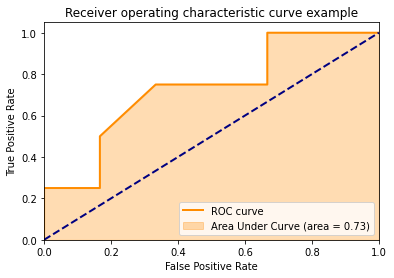

In [0]:
fpr, tpr, _ = sklearn.metrics.roc_curve(toy_example['class'], toy_example['prediction'])

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.fill_between(fpr, tpr, y2=0, color='darkorange', alpha=0.3, label='Area Under Curve (area = %0.2f)' % catboost_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve example')
plt.legend(loc="lower right")
plt.show()

Let's have a look at the toy_example objects and understand how each object impacted the ROC curve: 

![Binary AUC plot explained](https://habrastorage.org/webt/zc/jr/vx/zcjrvx5bn5darmm8soa7km5du3a.jpeg)

## AUC: Calculation with weights

CatBoost allows us to assign a weight to each object in the dataset for AUC calculation according to [the formula above](#scrollTo=4RbdSB4EMBZs).  If no weights assigned, all weights are equal to 1 and thus AUC is proportional to the number of correctly ordered pairs. If weights assigned this property is changed. 

Weights are useful for unbalanced datasets. If there is a class or a group of objects with a small number of samples in the train dataset it could be reasonable to increase the weights for corresponding objects. 

For example if we assign weight 10 to one object it can be understood as adding 9 of the same objects to the dataset.

Let's calculate AUC for an example of the wrong and right classification of one important object with weight = 10.

In [0]:
toy_example['weight'] = 1

In [0]:
roc_auc = catboost.utils.eval_metric(toy_example['class'], toy_example['prediction'], 'AUC', weight=toy_example['weight'])[0]
print('ROC AUC with default weights = {0:.4f}'.format(roc_auc))

ROC AUC with default weights = 0.7292


In [0]:
# seting weight=10 to important object with correct ordering
toy_example.iloc[0, 2] = 10
toy_example

,class,prediction,weight
0,1,0.90,10
4,0,0.80,1
2,1,0.60,1
1,1,0.40,1
7,0,0.40,1
8,0,0.30,1
5,0,0.25,1
3,1,0.20,1
6,0,0.15,1
9,0,0.10,1


In [0]:
roc_auc = catboost.utils.eval_metric(toy_example['class'], toy_example['prediction'], 'AUC', weight=toy_example['weight'])[0]
print('AUC: = {0:.4f}'.format(roc_auc))
print('Important object is correctly ordered, AUC increases')

AUC: = 0.9167
Important object is correctly ordered, AUC increases


In [0]:
# set weight=10 to important object with wrong ordering
toy_example['weight'] = 1
toy_example.iloc[1, 2] = 10
toy_example

,class,prediction,weight
0,1,0.90,1
4,0,0.80,10
2,1,0.60,1
1,1,0.40,1
7,0,0.40,1
8,0,0.30,1
5,0,0.25,1
3,1,0.20,1
6,0,0.15,1
9,0,0.10,1


In [0]:
roc_auc = catboost.utils.eval_metric(toy_example['class'], toy_example['prediction'], 'AUC', weight=toy_example['weight'])[0]
print('AUC: = {0:.4f}'.format(roc_auc))
print('Important object is incorrectly ordered, AUC decreases')

AUC: = 0.4417
Important object is incorrectly ordered, AUC decreases


# AUC for multiclass classification

There are two AUC metrics implemented for multiclass classification in Catboost. 

The first is **OneVsAll**. AUC value is calculated separately for each class according to the binary classification calculation principles. 

The second is **AUC$\mu$**, which is designed to meet the following properties:

* Property 1. If a model gives the correct label the highest probability 
on every example, then AUC = 1
* Property 2. Random guessing on examples yields AUC = 0.5
* Property 3. AUC is insensitive to class skew

AUC$\mu$ could be interpreted as an average of pairwise AUCs between the classes. Details could be found in the [article](http://proceedings.mlr.press/v97/kleiman19a/kleiman19a.pdf). 


### OneVsAll AUC

OneVsAll AUC in Catboost returns $n$ AUC values for $n$-class classification. The value is calculated separately for each class $k$ numbered from $0$ to $K–1$ according [to the binary classification calculation rules](#scrollTo=4RbdSB4EMBZs). The objects of class $k$ are considered positive, while all others are considered negative.

Let's create a small example and calculate OneVsAll AUC for 3 classes.

In [0]:
classes = [0, 1, 1, 0, 1, 1, 1, 0, 1, 2]

probas =\
np.array([[0.4799, 0.3517, 0.3182, 0.3625, 0.336 , 0.3034, 0.4284, 0.5497, 0.231  , 0.27 ],
       [0.2601, 0.3052, 0.3637, 0.3742, 0.3808, 0.3995, 0.3038, 0.2258, 0.264 , 0.4581],
       [0.2601, 0.3431, 0.3182, 0.2633, 0.2832, 0.2971, 0.2678, 0.2245,0.506 , 0.271 ]])

Let's calculate ROC AUC for each class using binary classification rules:

In [0]:
one_vs_all_df_example = pd.DataFrame({'class_0': classes, 'class_1': classes, 'class_2': classes, 'probability_of_0': probas[0, :], 'probability_of_1': probas[1, :], 'probability_of_2': probas[2, :]})
one_vs_all_df_example.loc[one_vs_all_df_example['class_0'] != 0, 'class_0'] = -1
one_vs_all_df_example.loc[one_vs_all_df_example['class_0'] == 0, 'class_0'] = 1
one_vs_all_df_example.loc[one_vs_all_df_example['class_0'] == -1, 'class_0'] = 0
one_vs_all_df_example.loc[one_vs_all_df_example['class_1'] != 1, 'class_1'] = 0
one_vs_all_df_example.loc[one_vs_all_df_example['class_1'] == 1, 'class_1'] = 1
one_vs_all_df_example.loc[one_vs_all_df_example['class_2'] != 2, 'class_2'] = 0
one_vs_all_df_example.loc[one_vs_all_df_example['class_2'] == 2, 'class_2'] = 1

In [0]:
one_vs_all_df_example

,class_0,class_1,class_2,probability_of_0,probability_of_1,probability_of_2
0,1,0,0,0.4799,0.2601,0.2601
1,0,1,0,0.3517,0.3052,0.3431
2,0,1,0,0.3182,0.3637,0.3182
3,1,0,0,0.3625,0.3742,0.2633
4,0,1,0,0.3360,0.3808,0.2832
5,0,1,0,0.3034,0.3995,0.2971
6,0,1,0,0.4284,0.3038,0.2678
7,1,0,0,0.5497,0.2258,0.2245
8,0,1,0,0.2310,0.2640,0.5060
9,0,0,1,0.2700,0.4581,0.2710


In [0]:
roc_aucs = []
for i in range(3):
  roc_aucs.append(catboost.utils.eval_metric(one_vs_all_df_example['class_' + str(i)], one_vs_all_df_example['probability_of_' + str(i)], 'AUC')[0])
  print('Binary Classification ROC AUC for class {0} = {1:.4f}'.format(i, roc_aucs[-1]))

Binary Classification ROC AUC for class 0 = 0.9524
Binary Classification ROC AUC for class 1 = 0.5833
Binary Classification ROC AUC for class 2 = 0.4444


Let's calculate the same metric with OneVsAll Catboost AUC and ensure everything is right:

In [0]:
aucs = eval_metric(classes, probas, 'AUC:type=OneVsAll')
for i in range(len(aucs)):
  print('OneVsAll ROC AUC for class {0} = {1:.4f}'.format(i, aucs[i]))

OneVsAll ROC AUC for class 0 = 0.9524
OneVsAll ROC AUC for class 1 = 0.5833
OneVsAll ROC AUC for class 2 = 0.4444


#### Visualizing ROC curves

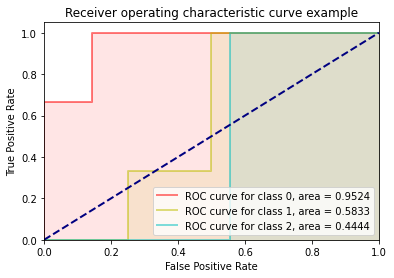

In [0]:
plt.figure()
lw = 2

colors = ['r', 'y', 'c']

for i in range(3):

  fpr, tpr, _ = sklearn.metrics.roc_curve(one_vs_all_df_example['class_' + str(i)], one_vs_all_df_example['probability_of_'  + str(i)])
  plt.plot(fpr, tpr, color=colors[i],
          lw=lw, label='ROC curve for class {0}, area = {1:.4f}'.format(i, roc_aucs[i]), alpha=0.5)
  plt.fill_between(fpr, tpr, y2=0, color=colors[i], alpha=0.1)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve example')
plt.legend(loc="lower right")
plt.show()

#### OneVsAll AUC with weights

In [0]:
# setting a big weight to incorrectly classified object of class 1 (misclassified as 2)
AUCs = eval_metric(classes, probas, weight=[1, 1, 1, 1, 1, 1, 1, 1, 10, 1], metric='AUC:type=OneVsAll')
print('CalBoost OneVsAll AUC with weights:')
print('AUC:class=0 = {0:.4f}, AUC:class=1 = {1:.4f}, AUC:class=2 = {2:.4f}'.format(AUCs[0], AUCs[1], AUCs[2]))

CalBoost OneVsAll AUC with weights:
AUC:class=0 = 0.9792, AUC:class=1 = 0.5333, AUC:class=2 = 0.2222


In [0]:
# setting a big weight to correctly classified object of class 0
AUCs = eval_metric(classes, probas, weight=[10, 1, 1, 1, 1, 1, 1, 1, 1, 1], metric='AUC:type=OneVsAll')
print('CalBoost OneVsAll AUC with weights:')
print('AUC:class=0 = {0:.4f}, AUC:class=1 = {1:.4f}, AUC:class=2 = {2:.4f}'.format(AUCs[0], AUCs[1], AUCs[2]))

CalBoost OneVsAll AUC with weights:
AUC:class=0 = 0.9881, AUC:class=1 = 0.8718, AUC:class=2 = 0.7222


Weights of the objects would affect AUC values for all classes as all objects of the other classes are used in the calculation as objects of class 0.  

OneVsAll AUC measures the ability of the classifier to distinguish objects of one class from another. 

An advantage of OneVsAll is the ability to monitor performance on different classes separately. 

## AUC$\mu$

AUC$\mu$ could be simply used as an evaluation metric to prevent overfitting, while OneVsAll AUC could not as it contains a metric value for each class and AUCs for different classes may vary inconsistently during training. 

Let's have a look at the AUC$\mu$ formula:

$$
AUC\mu = \frac{2}{K(K - 1)}\sum_{i<j} S(i, j) 
$$

$K$ is a number of classes, $i < j ≤ K$ are the classes' numbers.

$S(i, j)$ is a separability measure between classes $i$ and $j$ defined as:

$$
S(i, j) = \frac{1}{n_i n_j}\sum_{a \in D_i, b \in D_j} \hat{I} \circ O(y^{(a)}, y^{(b)}, \hat{p}^{(a)}, \hat{p}^{(b)}, v_{i, j}),
$$

where 

* $\hat I$ is indicator function applied to results of $O$, which returns 1 if $O$ returns a positive value, 0 if $O$ returns a negative value, and 0.5 if $O$ returns 0.

* $O$ is an orientation function indicating if the two instances are ordered correctly, incorrectly, or tied. $O$ returns a positive value if the predictions are ranked correctly, a negative
value if they are ranked incorrectly, and 0 if their rank is
tied. 


* $a$,  $b$ are objects from classes $i$, $j$ respectively, 
* $\hat{p}^{(a)}$, $\hat{p}^{(b)}$ are vectors of predicted probabilities of the object to belong to the classes,  
* $y^{(a)}$, $y^{(b)}$ are true labels of objects $a$, $b$ (one-hot vectors),
* $v_{i, j}$ is a two-class decision hyperplane normal vector.



$O$ is caclulates as following:


$O(y^{(a)}, y^{(b)}, \hat{p}^{(a)}, \hat{p}^{(b)}, v_{i, j}) = v_{i, j} (y^{(a)} - y^{(b)}) v_{i, j} (\hat{p}^{(a)} - \hat{p}^{(b)})$

Vectors $v_{i, j}$ come from misclassification cost matrix $A$, which is defined manually following the learning task. 

$v_{i,j} = A_{i,.} - A_{j,.}$

$A_{i,j}$ is the cost of classifying an instance as class $i$
when its true class is $j$. Then $A$ defines a partition on the
$(K − 1)$−simplex and induces decision boundaries between
the $K$ classes. 

Default misclassification cost matrix values are 1 everywhere, except the diagonal where they are 0. It is called the argmax partition
matrix as it assigns a class with maximal probability.

Here is a partition for a 3-class classification problem with the argmax partition matrix A. For a user-defined partition matrix the boundaries (marked by arrows) are shifted.

![argmax partition matrix visualisation](https://habrastorage.org/webt/h_/9y/jh/h_9yjhimj9yidj3y1nritttbhsc.jpeg)




Follow [the article](http://proceedings.mlr.press/v97/kleiman19a/kleiman19a.pdf) for more details.

CatBoost allows us to set the misclassification cost matrix $A$ and objects' weights to calculate $AUC\mu$. 



Let's calculate $AUC\mu$ for a very small example with 3 classes and 4 objects:

In [0]:
classes = np.array([2, 1, 0, 2])

y = np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0], [0, 0, 1]])

probas = np.array([[0.3, 0.5, 0.2], [0.4, 0.5, 0.1], [0.4, 0.15, 0.45], [0.05, 0.5, 0.45]])

K = 3

A = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])

In [0]:
def get_I(value):
  if value > 0:
    return 1
  elif value == 0:
    return 0.5
  return 0

Let's compute $S(i, j)$ for each ordered classes' pair:

In [0]:
# i = 0 (objects: y_2), j = 1 (objects: y_1) 
v_01 = A[0, :] - A[1, :]
s_01 = get_I(v_01.dot(y[2] - y[1]) * v_01.dot(probas[2] - probas[1]))

In [0]:
# i = 0 (objects: y_2), j = 2 (objects: y_0, y_3) 
v_02 = A[0, :] - A[2, :]
s_02 = 1 / (1 * 2) * (get_I(v_02.dot(y[2] - y[0]) * v_02.dot(probas[2] - probas[0])) + \
       get_I(v_02.dot(y[2] - y[3]) * v_02.dot(probas[2] - probas[3])))

In [0]:
# i = 1 (objects: y_1), j = 2 (objects: y_0, y_3) 
v_12 = A[1, :] - A[2, :]
s_12 = 1 / (1 * 2) * (get_I(v_12.dot(y[1] - y[0]) * v_02.dot(probas[1] - probas[0])) + \
       get_I(v_12.dot(y[1] - y[3]) * v_02.dot(probas[1] - probas[3])))

In [0]:
AUC_mu = 2 / (K * (K - 1)) * (s_01 + s_02 + s_12)
print('AUC_mu = {:.4f}'.format(AUC_mu))

AUC_mu = 0.8333


Let's calculate the same metric with Catboost $AUC\mu$ and ensure everything is right:

In [0]:
print('Catboost AUC_mu = {:.4f}'.format(eval_metric(classes, probas.T, 'AUC:type=Mu')[0]))

Catboost AUC_mu = 0.8333


Let's calculate OneVsAll AUC for the same data:

In [0]:
AUCs = eval_metric(classes, probas.T, metric='AUC:type=OneVsAll')
print('AUC:class=0 = {0:.4f}, AUC:class=1 = {1:.4f}, AUC:class=2 = {2:.4f}'.format(AUCs[0], AUCs[1], AUCs[2]))

AUC:class=0 = 0.8333, AUC:class=1 = 0.6667, AUC:class=2 = 0.6250


As we can see OneVsAll AUC and $AUC\mu$ are pretty high, but actually algorithm performance is bad, accuracy is 0.25. Thus it is reasonable to evaluate other important metrics during training.



In [0]:
print('Accuracy = {:.4f}'.format(eval_metric(classes, probas.T, metric='Accuracy')[0]))

Accuracy = 0.2500


#### $AUC\mu$ with misclassification cost matrix and weights

In [0]:
AUC = eval_metric(classes, probas.T, weight=[1, 10, 1, 1], metric='AUC:type=Mu;misclass_cost_matrix=0/0.5/2/1/0/1/0/0.5/0')

In [0]:
print('Catboost AUC_mu with weights = {:.4f}'.format(AUC[0]))

Catboost AUC_mu with weights = 0.1667


$AUC\mu$ is a good generalizing metric to estimate algorithm ability to separate classes in multiclassification problems. See more about different approaches to multiclass AUC calculation and their properties in section 4.3 of [the article](http://proceedings.mlr.press/v97/kleiman19a/kleiman19a.pdf).

AUC$\mu$ could be interpreted as an average of pairwise AUCs between the classes. AUC$\mu$ is a single value unlike OneVsAll AUC and thus it could be used as an evaluation metric during training for overfitting detection and trees pruning.

# AUC for ranking

There are two variants of AUC for Ranking in CatBoost.

### The Classic AUC
is used for models with Logloss and CrossEntropy loss functions. It has the same formula as AUC for binary classification:

$$
\frac{\sum I(a_i, a_j) w_i w_j}{\sum{w_i w_j}} 
$$

$a_i, a_j$ - predicted rank of objects i, j.

The sum is calculated on all pairs of objects $i, j$ such that:
$t_i = 0, t_j = 1$ where $t$ is relevance.

$$
I(a_i, a_j) =
  \begin{cases}
    1    & \quad \text{if } a_i < a_j\\
    0.5  & \quad \text{if } a_i = a_j\\
    0    & \quad \text{if } a_i > a_j\\
  \end{cases}
$$

The formula above suits for simple tasks with target values equal to 1 and 0. What if we have more target values? 

If the target type is not binary, then every object $i$ with target value $t$ and weight $w$ is replaced with two objects for the metric calculation:

* $\sigma_1$ with weight $wt$ and target value 1
* $\sigma_2$ with weight $w(1 - t)$ and target value 0.

Target values must be in the range [0; 1].




Let's calculate Classic AUC for Ranking for a small example. Assume we have 2 documents, 2 requests, corresponding relevances in the range [1, 5] and predicted relevance in the range [0, 1]:


In [0]:
rank_df = pd.DataFrame({'request_id': [1, 1, 2, 2], 'doc_id': [1, 2, 1, 2], 'relevance': [2, 5, 4, 1], 'pred':[0.3, 0.7, 0.2, 0.6], 'weight': [1, 1, 1, 1]})
#map relevence to [0, 1]
rank_df.loc[:, 'relevance'] /= 5
rank_df.sort_values(by='pred', axis=0, inplace=True)
rank_df

,request_id,doc_id,relevance,pred,weight
2,2,1,0.8,0.2,1
0,1,1,0.4,0.3,1
3,2,2,0.2,0.6,1
1,1,2,1.0,0.7,1


Let's create objects $\sigma$ required for calculation and update weights:

In [0]:
rank_df_sigma = pd.concat([
    rank_df,rank_df
],ignore_index=True)
rank_df_sigma['new_relevance'] = 0
rank_df_sigma.loc[:3, 'new_relevance'] = 1
rank_df_sigma['new_weight'] = rank_df_sigma['weight']

In [0]:
rank_df_sigma.loc[rank_df_sigma['new_relevance'] == 1, 'new_weight'] = rank_df_sigma['relevance'] * rank_df_sigma['weight']
rank_df_sigma.loc[rank_df_sigma['new_relevance'] == 0, 'new_weight'] = (1 - rank_df_sigma['relevance']) * rank_df_sigma['weight']
rank_df_sigma.sort_values(by='pred', axis=0, ascending=False, inplace=True)
rank_df_sigma

,request_id,doc_id,relevance,pred,weight,new_relevance,new_weight
3,1,2,1.0,0.7,1,1,1.0
7,1,2,1.0,0.7,1,0,0.0
2,2,2,0.2,0.6,1,1,0.2
6,2,2,0.2,0.6,1,0,0.8
1,1,1,0.4,0.3,1,1,0.4
5,1,1,0.4,0.3,1,0,0.6
0,2,1,0.8,0.2,1,1,0.8
4,2,1,0.8,0.2,1,0,0.2


Let's calculate AUC:

In [0]:
# finding sum of weights for denominator
weights1 = rank_df_sigma.loc[rank_df_sigma['new_relevance'] == 1, 'new_weight'].to_numpy()
weights0 = rank_df_sigma.loc[rank_df_sigma['new_relevance'] == 0, 'new_weight'].to_numpy()

Calculation details for object #3:

![classical ranking AUC calculation](https://habrastorage.org/webt/gq/in/iy/gqiniyqqhdgpd3fqckbdlwgvk4w.jpeg)


In [0]:
denominator = np.sum(weights1.reshape(-1, 1)@weights0.reshape(1, -1))
# for each object of class 1 find objects of class 0 below and add composition of weights and indicatior function to the numerator 
numerator = 1 * (0.8 + 0.6 + 0.2) + 0.2 * (0.8 * 0.5 + 0.6 + 0.2) + 0.4 * (0.6 * 0.5 + 0.2) + 0.8 * 0.2 * 0.5
manually_calculated_auc = numerator / denominator
print('Example of manually calculated Classic ROC AUC for ranking = {0:.4f}'.format(manually_calculated_auc))

Example of manually calculated Classic ROC AUC for ranking = 0.5521


In [0]:
print('CatBoost Classic ROC AUC for ranking = {0:.4f}'.format(eval_metric(rank_df['relevance'], rank_df['pred'], 'AUC:type=Classic')[0]))

CatBoost Classic ROC AUC for ranking = 0.5521


## Ranking AUC

Ranking AUC is used for ranking loss functions.

$$
\frac{\sum I(a_i, a_j) w_i w_j}{\sum{w_i w_j}} 
$$

$a_i, a_j$ - predicted rank of objects i, j.

The sum is calculated on all pairs of objects $i, j$ such that:
$t_i < t_j$ where $t$ is relevance.

$$
I(a_i, a_j) =
  \begin{cases}
    1    & \quad \text{if } a_i < a_j\\
    0.5  & \quad \text{if } a_i = a_j\\
    0    & \quad \text{if } a_i > a_j\\
  \end{cases}
$$


Let's compute Ranking AUC for the small example above:

In [0]:
rank_df.sort_values(by='relevance', axis=0, inplace=True, ascending=False)
rank_df

,request_id,doc_id,relevance,pred,weight
1,1,2,1.0,0.7,1
2,2,1,0.8,0.2,1
0,1,1,0.4,0.3,1
3,2,2,0.2,0.6,1


Calculation details:

![ranking AUC calculation details](https://habrastorage.org/webt/rk/8w/ka/rk8wkacwlc9sw3tqq2bgitqti-m.jpeg)

In [0]:
n = rank_df['relevance'].unique().shape[0]
denominator = (n * (n-1)) / 2 #number of ordered pairs
# for object #1 three object below are less relevant by real relevance and predictions, the other are incorrectly ranked 
numerator = 3
manually_calculated_auc = numerator / denominator
print('Example of manually calculated Ranking ROC AUC = {0:.4f}'.format(manually_calculated_auc))

Example of manually calculated Ranking ROC AUC = 0.5000


In [0]:
print('CatBoost Ranking ROC AUC = {0:.4f}'.format(eval_metric(rank_df['relevance'], rank_df['pred'], 'AUC:type=Ranking', group_id=rank_df['request_id'])[0]))

CatBoost Ranking ROC AUC = 0.5000


Ranking AUC is directly measuring the quantity of correctly ranked pairs. The problem is the metric is calculated regardless of groups. In our example, we have groups (requests) and we may want to measure quality inside the groups, but currently, AUC is calculated over the dataset and AUC penalizes us if, for example, top-one document for one request is ranked lower than top-one for another document while true ranks are opposite (but still top-one for each document).

One more problem of AUC for Ranking is that it does not distinguish the top object from the others. If we have a lot of irrelevant documents, which are ranked irrelevant by the model, but bad ranking in top-10, AUC could still be high because of that "tail" of irrelevant objects, ranked lower than relevant. 

#Overview

AUC is a widely used metric to measure the ability of a model to distinguish classes and correctly order objects from different classes / with different relevance. AUC is not differentiable and thus cannot be used as a loss function, but it is pretty informative and useful as a metric. 

We have examined the following AUC types:
* AUC for binary classification. It is a classical metric, which measures the model quality. ROC curve allows selecting the probability threshold to meet required False Positive or False Negative Rates. 

* AUC for multiclass classification: OneVsAll and $AUC\mu$. OneVsAll AUC helps to control algorithm performance for each class, but can not be used as a metric to prevent overfitting. On the contrary, $AUC\mu$ is good as a generalizing metric, but will not detect a problem with one class.

* AUC for ranking: Classic AUC and Ranking AUC. AUC suits for ranking tasks because it is designed to measure how the algorithm distinguishes between classes and it is simply transferring to distinguishing between relevant and irrelevant objects. But AUC does not take into account that in ranking problems the first $n$ positions are very important and treats each correctly ordered pair of documents equally.   





# How to use AUC in Catboost on real datasets? 

AUC implemented in CatBoost allows using weights to consider object and classes' importance in metric calculation. 
You can use AUC in Catboost during training as a validation metric to prevent overfitting and select the best model and as a metric to compare different models' results. 

Let's consider an example of using AUC for a multiclassification task.

### AUC for multiclass classification

#### Loading dataset

We will use the [Wine recognition dataset](https://scikit-learn.org/stable/datasets/index.html#wine-dataset ) for multiclass classification problem

In [0]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data

--2020-03-29 14:50:55--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10782 (11K) [application/x-httpd-php]
Saving to: ‘wine.data’

wine.data           100%[===================>]  10.53K  --.-KB/s    in 0s      

2020-03-29 14:50:55 (118 MB/s) - ‘wine.data’ saved [10782/10782]



In [0]:
columns = ['Class', 'Alcohol', 'Malic_acid', 'Ash', 'Alcalinity_of_ash', 'Magnesium', 'Total_phenols', 'Flavanoids', 'Nonflavanoid_phenols', 'Proanthocyanins', 'Color_intensity', 'Hue', 'OD280OD315_of_diluted_wines', 'Proline']
train_df = pd.read_csv('wine.data', names=columns)

In [0]:
train_df.head(5)

,Class,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280OD315_of_diluted_wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


#### Creating pool

In [0]:
y = train_df['Class']
X = train_df.drop(columns='Class')
y.unique()

array([1, 2, 3])

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.5, random_state=42)

In [0]:
train_pool = Pool(X_train, y_train)
validation_pool = Pool(X_validation, y_validation)

#### Training model

In [0]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=20,
    eval_metric='AUC',
    custom_metric=['AUC:type=OneVsAll;hints=skip_train~false', 'Accuracy'],
    # metric_period=10,
    loss_function='MultiClass',
    train_dir='model_dir',
    random_seed=42)

model.fit(
    train_pool,
    eval_set=validation_pool,
    verbose=True, 
);

Learning rate set to 0.458482
0:	test: 0.9222371	best: 0.9222371 (0)	total: 3.39ms	remaining: 64.5ms
1:	test: 0.9777926	best: 0.9777926 (1)	total: 6.04ms	remaining: 54.4ms
2:	test: 0.9846999	best: 0.9846999 (2)	total: 8.45ms	remaining: 47.9ms
3:	test: 0.9808378	best: 0.9846999 (2)	total: 10.7ms	remaining: 42.7ms
4:	test: 0.9787582	best: 0.9846999 (2)	total: 13.2ms	remaining: 39.5ms
5:	test: 0.9763815	best: 0.9846999 (2)	total: 15.5ms	remaining: 36.1ms
6:	test: 0.9786096	best: 0.9846999 (2)	total: 17.9ms	remaining: 33.3ms
7:	test: 0.9786096	best: 0.9846999 (2)	total: 20.4ms	remaining: 30.6ms
8:	test: 0.9839572	best: 0.9846999 (2)	total: 22.6ms	remaining: 27.6ms
9:	test: 0.9839572	best: 0.9846999 (2)	total: 25ms	remaining: 25ms
10:	test: 0.9839572	best: 0.9846999 (2)	total: 27.5ms	remaining: 22.5ms
11:	test: 0.9848485	best: 0.9848485 (11)	total: 30ms	remaining: 20ms
12:	test: 0.9854427	best: 0.9854427 (12)	total: 32.4ms	remaining: 17.4ms
13:	test: 0.9854427	best: 0.9854427 (12)	total: 35

Model is shrinked to the first best $AUC\mu$ value (17 iteration)  

#### Calculating metrics

In [0]:
AUCs = model.eval_metrics(validation_pool, metrics=['AUC:type=Mu', 'AUC:type=OneVsAll'])

In [0]:
print('AUC:type=OneVsAll:')
print('AUC:class=0 = {0:.4f}, AUC:class=1 = {1:.4f}, AUC:class=2 = {2:.4f}'.format(AUCs['AUC:class=0'][-1], AUCs['AUC:class=1'][-1], AUCs['AUC:class=2'][-1]))

print('\nAUC:type=Mu:')
print('AUC:type=Mu = {0:.5f}'.format(AUCs['AUC:type=Mu'][-1]))

AUC:type=OneVsAll:
AUC:class=0 = 0.9827, AUC:class=1 = 0.9690, AUC:class=2 = 1.0000

AUC:type=Mu:
AUC:type=Mu = 0.98841


Using weigths and misclassification cost matrix:

In [0]:
weights = np.random.rand(X_validation.shape[0])
weights[10] = 100
validation_pool = Pool(X_validation, y_validation, weight=weights)

In [0]:
AUC = model.eval_metrics(validation_pool, metrics=['AUC:type=Mu', 'AUC:type=Mu;use_weights=True', 'AUC:type=Mu;misclass_cost_matrix=0/0.5/2/1/0/1/0/0.5/0;use_weights=True'])

In [0]:
print('AUC:type=Mu = {0:.5f}'.format(AUC['AUC:type=Mu'][-1]))
print('AUC:type=Mu;use_weights=True = {0:.5f}'.format(AUC['AUC:use_weights=true;type=Mu'][-1]))
print('AUC:use_weights=true;type=Mu;misclass_cost_matrix = {0:.5f}'.format(AUC['AUC:use_weights=true;type=Mu;misclass_cost_matrix=0/0.5/2/1/0/1/0/0.5/0'][-1]))

AUC:type=Mu = 0.98841
AUC:type=Mu;use_weights=True = 0.94668
AUC:use_weights=true;type=Mu;misclass_cost_matrix = 0.96956
